In [2]:
import os, time, sys, copy, json, shutil, subprocess
import numpy as np

# ====== CONFIG ======
N_SAMPLES = 10000
OUT_HR = "hr_all_lsst_regr_2.npy"
OUT_LR = "lr_all_lsst_regr_2.npy"
PARAMS_JSONL = "params_all_lsst_regr_2.jsonl"
PARAMS_JSONL_TMP = PARAMS_JSONL + ".tmp"

WITH_SUBSTRUCTURE = True
LOG_EVERY = 1000
SAVE_CHECKPOINT_EVERY = 2000
BAND = "F129"
FOV_ARCSEC = 5
EXPTIME_SEC = 146  # typical Roman single exposure

# ====== ENV ======
os.environ["ROMAN_TECHNICAL_INFORMATION_PATH"] = "/home/imglab/Sasha/DeepLense/grav_lens_diff/Mejiro_dataset/mejiro/roman-technical-information"

# Point the kernel to CUDA 12 toolchain & libs (optional but kept from your original)
os.environ['PATH'] = '/usr/local/cuda-12/bin:' + os.environ.get('PATH','')
os.environ['LD_LIBRARY_PATH'] = (
    f"{os.environ.get('CONDA_PREFIX','')}/lib:/usr/local/cuda-12/lib64:"
    + os.environ.get('LD_LIBRARY_PATH','')
)
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-12'
os.environ['JAX_PLATFORM_NAME'] = 'cuda'

# Sanity-check what this kernel sees
print("ptxas:", shutil.which('ptxas'))
subprocess.run(['ptxas','--version'], check=False)

# ====== IMPORTS (from your code/libs) ======
from pyHalo.preset_models import preset_model_from_name
from mejiro.exposure import Exposure
from mejiro.instruments.roman import Roman
from mejiro.galaxy_galaxy import GalaxyGalaxy, SampleGG
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import lenstronomy_util
from mejiro.engines.galsim_engine import GalSimEngine
from mejiro.engines.stpsf_engine import STPSFEngine

# ====== HELPERS ======
def to_numpy_force(img):
    if hasattr(img, "get_array"): return img.get_array()
    if hasattr(img, "array"): return img.array
    if isinstance(img, np.ndarray): return img
    raise TypeError(f"Unsupported image type: {type(img)}")

def _clip_e(kwargs_obj, e1='e1', e2='e2', m=0.6):
    e1v, e2v = kwargs_obj.get(e1, 0.0), kwargs_obj.get(e2, 0.0)
    mag = float(np.sqrt(e1v**2 + e2v**2))
    if mag > m and mag > 0:
        s = m/mag
        kwargs_obj[e1] = float(e1v * s)
        kwargs_obj[e2] = float(e2v * s)

def _safe_float(x, default=np.nan):
    try:
        v = float(x)
        if not np.isfinite(v): return default
        return v
    except Exception:
        return default

# ====== RANDOMIZED LENS/SOURCE MODEL ======
class RandomGG(GalaxyGalaxy):
    def __init__(self):
        base = SampleGG()
        p = copy.deepcopy(base.kwargs_params)

        # Lens variations
        p['kwargs_lens'][0]['theta_E'] *= np.random.uniform(0.5, 1.5)
        for k in ['e1','e2']:
            p['kwargs_lens'][0][k] += np.random.uniform(-0.15, 0.15)
        _clip_e(p['kwargs_lens'][0])

        # Source variations
        p['kwargs_source'][0]['center_x'] += np.random.uniform(-0.6, 0.6)
        p['kwargs_source'][0]['center_y'] += np.random.uniform(-0.6, 0.6)
        p['kwargs_source'][0]['R_sersic'] *= np.random.uniform(0.5, 2.0)
        for k in ['e1','e2']:
            p['kwargs_source'][0][k] += np.random.uniform(-0.15, 0.15)
        _clip_e(p['kwargs_source'][0])
        p['kwargs_source'][0]['n_sersic'] = float(np.random.uniform(0.5, 4.0))

        super().__init__(name="RandomGG",
                         coords=None,
                         kwargs_model=base.kwargs_model,
                         kwargs_params=p,
                         physical_params=base.physical_params,
                         use_jax=[True, True, True])

# ====== SHARED INSTRUMENT + PSF + ENGINE ======
roman = Roman()
kwargs_numerics = dict(SyntheticImage.DEFAULT_KWARGS_NUMERICS)
kwargs_numerics['supersampling_factor'] = 1  # speed

instrument_params = roman.default_params()

kernel = STPSFEngine.get_roman_psf(
    band=BAND,
    detector=instrument_params['detector'],
    detector_position=instrument_params['detector_position'],
    oversample=kwargs_numerics['supersampling_factor'],
    num_pix=51,  # 51 for speed (use 101 for broader PSF)
    verbose=False
)
kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(
    kernel=kernel,
    supersampling_factor=kwargs_numerics['supersampling_factor']
)

engine = 'galsim'
engine_params = GalSimEngine.defaults(roman.name)

# ====== RECORD EXTRACTION ======
def extract_record(idx, strong_lens, *, with_substructure, sub_info, exptime):
    p = copy.deepcopy(strong_lens.kwargs_params)
    lens0 = (p.get('kwargs_lens') or [{}])[0]
    src0  = (p.get('kwargs_source') or [{}])[0]

    ein = _safe_float(strong_lens.get_einstein_radius(), default=np.nan)
    mhost = _safe_float(strong_lens.get_main_halo_mass(), default=np.nan)

    rec = {
        "index": idx,
        "seed_render": (idx * 8635) & 0x5fffffff,
        "seed_noise":  (idx * 9176) & 0x7fffffff,
        "with_substructure": bool(with_substructure),
        "substructure": sub_info,
        "band": BAND,
        "fov_arcsec": FOV_ARCSEC,
        "exptime_sec": exptime,
        "targets": {
            "einstein_radius": ein,
            "main_halo_mass": mhost
        },
        "lens": {
            "theta_E": _safe_float(lens0.get("theta_E")),
            "e1": _safe_float(lens0.get("e1")),
            "e2": _safe_float(lens0.get("e2")),
            "gamma": _safe_float(lens0.get("gamma", np.nan)),
            "center_x": _safe_float(lens0.get("center_x", 0.0)),
            "center_y": _safe_float(lens0.get("center_y", 0.0)),
        },
        "source": {
            "center_x": _safe_float(src0.get("center_x")),
            "center_y": _safe_float(src0.get("center_y")),
            "R_sersic": _safe_float(src0.get("R_sersic")),
            "n_sersic": _safe_float(src0.get("n_sersic")),
            "e1": _safe_float(src0.get("e1")),
            "e2": _safe_float(src0.get("e2")),
        },
    }
    return rec

# ====== ONE SAMPLE ======
def make_pair(idx, with_substructure=True, max_attempts=4):
    # Seed controls RandomGG parameter draws
    np.random.seed((idx * 8635) & 0x5fffffff)

    attempt = 0
    sub_info = {
        "used": False,
        "cone_opening_angle_arcsec": None,
        "two_halo_contribution": None,
        "sigma_sub": 0.055,
        "LOS_normalization": 0.0,
        "log_mlow": 6.0,
        "log_mhigh": 10.0,
        "log_m_host": None,
        "r_tidal": 0.5
    }

    while True:
        attempt += 1
        strong_lens = RandomGG()

        # --- optional substructure ---
        if with_substructure:
            er = _safe_float(strong_lens.get_einstein_radius(), default=1.0)
            if not np.isfinite(er) or er <= 0: er = 1.0

            CDM = preset_model_from_name('CDM')
            cone_candidates = [max(3.0 * er, 3.0), 5.0, 10.0, 20.0]

            realization = None
            for angle in cone_candidates:
                for two_halo in (False, True):
                    try:
                        realization = CDM(
                            strong_lens.z_lens, strong_lens.z_source,
                            sigma_sub=sub_info["sigma_sub"],
                            cone_opening_angle_arcsec=float(angle),
                            LOS_normalization=sub_info["LOS_normalization"],
                            log_mlow=sub_info["log_mlow"], log_mhigh=sub_info["log_mhigh"],
                            log_m_host=np.log10(strong_lens.get_main_halo_mass()),
                            r_tidal=sub_info["r_tidal"],
                            two_halo_contribution=two_halo
                        )
                        sub_info.update({
                            "used": True,
                            "cone_opening_angle_arcsec": float(angle),
                            "two_halo_contribution": bool(two_halo),
                            "log_m_host": float(np.log10(strong_lens.get_main_halo_mass()))
                        })
                        break
                    except Exception:
                        realization = None
                if realization is not None:
                    break

            if realization is None:
                if attempt < max_attempts:
                    continue  # retry with a fresh RandomGG
                else:
                    with_substructure = False  # fall back gracefully
            else:
                strong_lens.add_realization(realization)

        # ---- render HR (no PSF) and LR (PSF + exposure/noise) ----
        sim_hr = SyntheticImage(
            strong_lens, instrument=roman, band=BAND, fov_arcsec=FOV_ARCSEC,
            instrument_params=instrument_params, kwargs_numerics=kwargs_numerics,
            kwargs_psf=None, pieces=False, verbose=False
        )
        sim_blurred = SyntheticImage(
            strong_lens, instrument=roman, band=BAND, fov_arcsec=FOV_ARCSEC,
            instrument_params=instrument_params, kwargs_numerics=kwargs_numerics,
            kwargs_psf=kwargs_psf, pieces=False, verbose=False
        )

        # Apply finite exposure + detector/sky noise via GalSim engine
        local_engine_params = dict(engine_params)
        local_engine_params['seed'] = (idx * 9176) & 0x7fffffff  # stable but varied noise
        exposure = Exposure(
            sim_blurred,
            exposure_time=EXPTIME_SEC,
            engine='galsim',
            engine_params=local_engine_params,
            verbose=False
        )

        hr = to_numpy_force(sim_hr.image).astype(np.float32)
        lr = to_numpy_force(exposure.image).astype(np.float32)

        record = extract_record(
            idx, strong_lens,
            with_substructure=with_substructure,
            sub_info=sub_info,
            exptime=EXPTIME_SEC
        )

        return hr, lr, record

# ====== SIMPLE PROGRESS BAR ======
def prog(i, n, t_per, start_time):
    done = i
    total = n
    frac = done/total
    barlen = 30
    fill = int(barlen*frac)
    bar = "#"*fill + "-"*(barlen-fill)
    elapsed = time.time() - start_time
    rem = (total - done) * (t_per if t_per > 0 else 0.0)
    msg = f"\r[{bar}] {done}/{total}  {frac*100:5.1f}%  ~{t_per:.3f}s/it  ETA {rem/60:5.1f} min"
    sys.stdout.write(msg); sys.stdout.flush()

# ====== DRIVER ======
def main():
    print(f"Generating {N_SAMPLES} pairs with substructure={WITH_SUBSTRUCTURE}")
    t0 = time.time()

    # Warmup + shape
    hr0, lr0, rec0 = make_pair(0, with_substructure=WITH_SUBSTRUCTURE)
    H, W = hr0.shape
    assert lr0.shape == (H, W), f"HR {hr0.shape} vs LR {lr0.shape}"
    print(f"Image shape: {H}x{W}, dtype float32")

    # Preallocate
    hr_all = np.empty((N_SAMPLES, H, W), dtype=np.float32)
    lr_all = np.empty((N_SAMPLES, H, W), dtype=np.float32)
    records = []

    hr_all[0] = hr0; lr_all[0] = lr0
    records.append(rec0)

    # Loop
    t_per = 0.0
    tick = time.time()
    start = tick
    prog(1, N_SAMPLES, 0.001, start)

    for i in range(1, N_SAMPLES):
        hr, lr, rec = make_pair(i, with_substructure=WITH_SUBSTRUCTURE)
        hr_all[i] = hr
        lr_all[i] = lr
        records.append(rec)

        if (i % LOG_EVERY) == 0:
            dt = time.time() - tick
            t_per = dt / LOG_EVERY
            tick = time.time()
            prog(i+1, N_SAMPLES, t_per, start)

        if (i % SAVE_CHECKPOINT_EVERY) == 0:
            np.save(OUT_HR + ".tmp.npy", hr_all[:i+1])
            np.save(OUT_LR + ".tmp.npy", lr_all[:i+1])
            # JSONL checkpoint
            with open(PARAMS_JSONL_TMP, "w") as f:
                for r in records:
                    f.write(json.dumps(r) + "\n")

    print("\nSaving final arrays...")
    np.save(OUT_HR, hr_all)
    np.save(OUT_LR, lr_all)

    # Final JSONL write (atomic via replace)
    with open(PARAMS_JSONL_TMP, "w") as f:
        for r in records:
            f.write(json.dumps(r) + "\n")
    os.replace(PARAMS_JSONL_TMP, PARAMS_JSONL)

    total = time.time() - t0
    print(f"Done in {total/60:.1f} min  (~{total/N_SAMPLES:.3f}s per pair incl. warmup)")

    # cleanup temps
    try:
        os.remove(OUT_HR + ".tmp.npy")
        os.remove(OUT_LR + ".tmp.npy")
    except Exception:
        pass

if __name__ == "__main__":
    main()


ptxas: /usr/local/cuda-12/bin/ptxas
ptxas: NVIDIA (R) Ptx optimizing assembler
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:14:55_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0
Generating 10000 pairs with substructure=True
Image shape: 47x47, dtype float32
[###########################---] 9001/10000   90.0%  ~1.609s/it  ETA  26.8 min
Saving final arrays...
Done in 270.4 min  (~1.622s per pair incl. warmup)


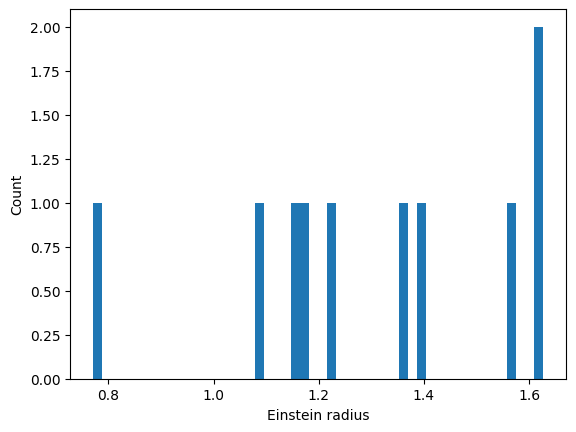

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_json("params_all_lsst_regr.jsonl", lines=True)

# each row's "targets" is a dict
df["targets"].iloc[0]  # {'einstein_radius': ..., 'main_halo_mass': ...}

# extract Einstein radius column
df["einstein_radius"] = df["targets"].apply(lambda t: t.get("einstein_radius", None))

import matplotlib.pyplot as plt
plt.hist(df["einstein_radius"].dropna(), bins=50)
plt.xlabel("Einstein radius")
plt.ylabel("Count")
plt.show()



In [5]:
import json
import pandas as pd

# Load JSONL into list of dicts
with open("params_all_lsst_regr.jsonl") as f:
    records = [json.loads(line) for line in f]

# Flatten nested dicts into columns
df = pd.json_normalize(records, sep=".")

# Inspect
print(df.head())          # first 5 rows
print(df.columns.tolist()) # see all available columns


   index  seed_render  seed_noise  with_substructure  band  fov_arcsec  \
0      0            0           0               True  F129           5   
1      1         8635        9176               True  F129           5   
2      2        17270       18352               True  F129           5   
3      3        25905       27528               True  F129           5   
4      4        34540       36704               True  F129           5   

   exptime_sec  substructure.used  substructure.cone_opening_angle_arcsec  \
0          146               True                                3.675302   
1          146               True                                4.189703   
2          146               True                                4.881895   
3          146               True                                3.528246   
4          146               True                                3.000000   

   substructure.two_halo_contribution  ...   lens.e2  lens.gamma  \
0                       

In [7]:
import pandas as pd

pd.set_option("display.max_rows", None)  # show all rows
pd.set_option("display.max_columns", None)  # show all columns
pd.set_option("display.width", 200)         # avoid wrapping too soon

print(df)  # or just df in Jupyter


   index  seed_render  seed_noise  with_substructure  band  fov_arcsec  exptime_sec  substructure.used  substructure.cone_opening_angle_arcsec  substructure.two_halo_contribution  \
0      0            0           0               True  F129           5          146               True                                3.675302                               False   
1      1         8635        9176               True  F129           5          146               True                                4.189703                               False   
2      2        17270       18352               True  F129           5          146               True                                4.881895                               False   
3      3        25905       27528               True  F129           5          146               True                                3.528246                               False   
4      4        34540       36704               True  F129           5          146       